# Chemical Embeddings

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
enamine_fingerprints_df = pd.read_csv('enamine_fingerprints.csv')

Hypothesis is that the smaller the SMILES the more fundamental the molecule

In [2]:
enamine_fingerprints_df['SMILES_length'] = enamine_fingerprints_df['SMILES'].apply(len)
enamine_fingerprints_df_sorted = enamine_fingerprints_df.sort_values(by='SMILES_length')
enamine_fingerprints_df_sorted = enamine_fingerprints_df_sorted.drop(columns=['SMILES_length'])

In [3]:
import ast

shortened_df = enamine_fingerprints_df_sorted[:20000]
df = shortened_df 
df['Morgan_fingerprint'] = df['Morgan_fingerprint'].apply(ast.literal_eval)

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_20902/2461128019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Morgan_fingerprint'] = df['Morgan_fingerprint'].apply(ast.literal_eval)


/opt/anaconda3/envs/chemical_language/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_20902/3131340857.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['UMAP1'] = embedding[:, 0]
/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_20902/3131340857.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

<Figure size 1000x800 with 0 Axes>

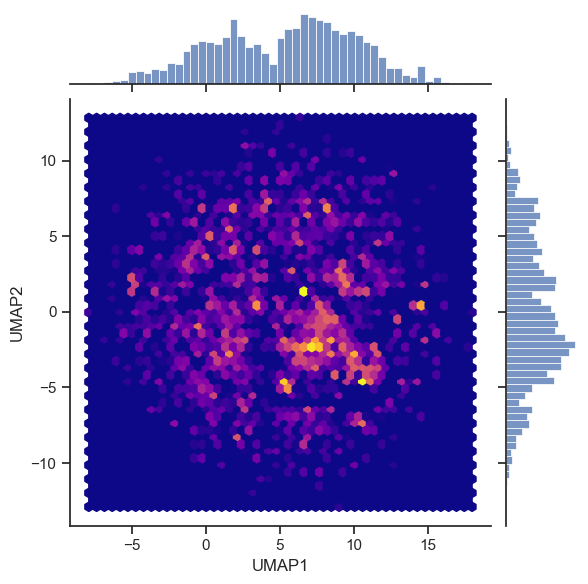

In [4]:
import pandas as pd
import numpy as np
import umap
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# df['Morgan_fingerprint'] = df['Morgan_fingerprint'].apply(ast.literal_eval)
fingerprints = np.array(df['Morgan_fingerprint'].tolist())

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Reduce to 100 dimensions
pcaed_prints = pca.fit_transform(fingerprints)

reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(pcaed_prints)

df['UMAP1'] = embedding[:, 0]
df['UMAP2'] = embedding[:, 1]
df.to_csv('playground_enamine_fingerprints.csv')

plt.figure(figsize=(10, 8))

sns.set_theme(style="ticks")
sns.jointplot(data=df, x='UMAP1', y='UMAP2', kind="hex", cmap='plasma')

# plt.title('UMAP projection of Morgan Fingerprints')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


In [5]:
from utils.viz_utills import create_interactive_plot

create_interactive_plot(df, smiles_col='SMILES', x_col='UMAP1', y_col='UMAP2', hover_cols=['ZINC_ID', 'SMILES'])



/Users/yitongtseo/Documents/GitHub/ethical_necromancy/Chemical_Language(Glucose for now)/utils/viz_utills.py:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/yitongtseo/Documents/GitHub/ethical_necromancy/Chemical_Language(Glucose for now)/utils/viz_utills.py:6: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# SWINGING BACK FOR THE SCRAPING

Okay let's take a swing at Enamine Building Blocks, I found a list of 500K of them. that should be a good start.
Can we create their morgan fingerprints and cluster them?

Taken from https://zinc12.docking.org/db/byvendor/enaminebb/enaminebb.in


In [ ]:
enamine_df = pd.read_csv('enaminebb.in.txt', delimiter=' ', index_col=False)

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import os

def get_single_molecule_embedding(smiles, radius=5, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
        return list(fp)
    return None

def process_and_append(
    df, start_idx=0, chunk_size=1000, output_file="final_processed_data.csv"
):
    for start in tqdm(range(start_idx, len(df), chunk_size)):
        end = start + chunk_size
        chunk = df.iloc[start:end].copy()  # Using copy to safely modify the data
        chunk["Morgan_fingerprint"] = chunk["SMILES"].apply(
            get_single_molecule_embedding
        )
        mode = "a" if start > 0 else "w"  # 'w' for write on first chunk, 'a' for append on subsequent chunks
        header = start == 0  # Write header only for the first chunk
        chunk.to_csv(output_file, mode=mode, header=header, index=False)

def check_progress(output_file):
    """Check if the output file already exists and determine the last processed index"""
    try:
        if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
            df = pd.read_csv(output_file)
            last_index_processed = df.index[-1]
            return last_index_processed + 1
        else:
            return 0
    except FileNotFoundError:
        return 0

# Check for existing progress and determine where to resume
output_file = "enamine_fingerprints.csv"
start_index = check_progress(output_file)
print('whats start index? ', start_index)

# Process DataFrame from the last checkpoint
process_and_append(
    enamine_df, start_idx=start_index, chunk_size=1000, output_file=output_file
)


KeyboardInterrupt: 

# SCRAP:

In [ ]:
break

In [ ]:
import h5py

f = h5py.File('zinc_stock.hdf5', 'r+')


In [ ]:
import h5py

def print_h5_structure(name, obj):
    if isinstance(obj, h5py.Group):
        print(f"Group: {name}")
    elif isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name} - Shape: {obj.shape} - Data Type: {obj.dtype}")

def search_smiles_in_h5(file):
    smiles_datasets = []
    file.visititems(print_h5_structure)
    
    def check_for_smiles(name, obj):
        if isinstance(obj, h5py.Dataset):
            data = obj[:]
            if 'smiles' in name.lower() or 'smiles' in str(data).lower():
                smiles_datasets.append(name)
    
    file.visititems(check_for_smiles)
    
    return smiles_datasets

# Open the HDF5 file
file_path = 'zinc_stock.hdf5'
with h5py.File(file_path, 'r') as f:
    smiles_datasets = search_smiles_in_h5(f)
    if smiles_datasets:
        print("\nDatasets likely containing SMILES strings:")
        for dataset in smiles_datasets:
            print(dataset)
    else:
        print("\nNo SMILES strings found in the datasets.")


Group: table
Dataset: table/axis0 - Shape: (1,) - Data Type: |S9
Dataset: table/axis1 - Shape: (17422831,) - Data Type: int64
Dataset: table/block0_items - Shape: (1,) - Data Type: |S9
Dataset: table/block0_values - Shape: (1,) - Data Type: object

No SMILES strings found in the datasets.


In [ ]:
import h5py

def print_dataset_contents(file, dataset_name):
    data = file[dataset_name][:]
    print(f"Contents of {dataset_name}:")
    print(data)
    print()

file_path = 'zinc_stock.hdf5'
with h5py.File(file_path, 'r') as f:
    print_dataset_contents(f, 'table/axis0')
    print_dataset_contents(f, 'table/axis1')
    print_dataset_contents(f, 'table/block0_items')
    print_dataset_contents(f, 'table/block0_values')


In [ ]:
import pandas as pd
output_file = "processed_data.pkl"
enamine_df = pd.read_pickle(output_file)

In [ ]:
len(enamine_df)

We will use AIZynthFinder for the retrosynthesis planning

https://github.com/MolecularAI/aizynthfinder

https://molecularai.github.io/aizynthfinder/

In [ ]:
from aizynthfinder.interfaces import AiZynthApp
app = AiZynthApp("config.yml")


In [ ]:
%%time
!aizynthcli --config config.yml --smiles "COc1cccc(OC(=O)/C=C/c2cc(OC)c(OC)c(OC)c2)c1"

Loading template-based expansion policy model from /Users/yitongtseo/Documents/GitHub/ethical_necromancy/Chemical_Language(Glucose for now)/uspto_model.onnx to uspto
Loading templates from /Users/yitongtseo/Documents/GitHub/ethical_necromancy/Chemical_Language(Glucose for now)/uspto_templates.csv.gz to uspto
Loading template-based expansion policy model from /Users/yitongtseo/Documents/GitHub/ethical_necromancy/Chemical_Language(Glucose for now)/uspto_ringbreaker_model.onnx to ringbreaker
Loading templates from /Users/yitongtseo/Documents/GitHub/ethical_necromancy/Chemical_Language(Glucose for now)/uspto_ringbreaker_templates.csv.gz to ringbreaker
Loading filter policy model from /Users/yitongtseo/Documents/GitHub/ethical_necromancy/Chemical_Language(Glucose for now)/uspto_filter_model.onnx to uspto
Loading stock from InMemoryInchiKeyQuery to zinc
Selected as stock: zinc
Compounds in stock: 17422831
Selected as expansion policy: uspto
Selected as filter policy: uspto
Trees saved to tre

In [ ]:
from tqdm import tqdm
import pandas as pd

# Assuming enamine_df is your DataFrame and it has a column 'SMILES'
# Applying the fingerprint function to each SMILES entry
tqdm.pandas(desc="Generating fingerprints")
enamine_df["Morgan_fingerprint"] = enamine_df["SMILES"].progress_apply(
    get_single_molecule_embedding
)

In [ ]:
# import tqdm as tqdm

# # TODO: add a column to enamine_df that is called "Morgan_fingerprint"
# for idx, row in tqdm(enamine_df.iterrows(), total=len(enamine_df)):
#     enamine_df.iloc[idx]["Morgan Fingerprint"] = get_molecule_embeddings(
#         [row["SMILES"]]
#     )[0]

[10, 6, 4, 39, 44, 97, 38]

In [ ]:

# # # Example usage
# smiles_list = [
#     "C(C(=O)O)N",
#     "CCO",
#     "C1=CC=CC=C1",
#     "COc1cc2ccccc2cc1C(=O)O",
#     "c1ccc2c(c1)C(=O)c3cccc(c3C2=O)C(=O)O",
#     "c1cc(cc(c1)Oc2cccc(c2)C(F)(F)F)C3N(C(=O)CS3)CCN4CCCCC4",
#     "COC(=O)c1cccc(c1S(=O)(=O)F)N"
# ]  # Glycine, Ethanol, Benzene
# fingerprints = get_molecule_embeddings(smiles_list)
# # print(fingerprints)
# # print(fingerprints[0].sum())
# # print(fingerprints[1].sum())
# [fp.sum() for fp in fingerprints]

import numpy as np
# print(np.array(fingerprints[2]).where(1))
numpy_arr = np.array(fingerprints[2])
[idx for idx, val  in enumerate(numpy_arr) if val > 0]
fingerprints[2][389]

1

## Taking a step back... nouns can be just described by their constitutive atoms? But complex nouns then get out of grasp... like how would you chemically describe a human?

In [ ]:
import csv

# Writing to a CSV file
with open('most_common_words.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Word', 'Frequency'])  # Writing header
    writer.writerows(most_common_words)


# PubChem to the rescue

FTP to download all of the compounds in pubchem as a SMILES -> ftp://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-SMILES.gz
https://chemistry.stackexchange.com/questions/122109/how-to-get-the-smiles-of-all-compounds-on-pubchem 

Hopefully it's only a couple of gigabytes

Then to get the 1000 most common molecules is a bit difficult. but perhpas something I can do is just cheat:
* Either take the 1000 cheapest molecules
* Or take the 1000 molecules with the shortest SMILE strings (That ensures I get all of the elements, H2O, methane, etc.)

Maybe not necessary, but still may help is to bring them both down to the same dimension size with PCA
This step can help in normalizing the scale and variance of the datasets.
Especially if I bring them both lower... maybe 100?

* Canonical Correlation Analysis (CCA): If you seek more sophisticated statistical techniques, CCA can be used to find the relationships between two sets of variables. This might give insight`s into how molecular structures correlate with semantic meanings of words.
* Procrustes Analysis: This method is used to find the optimal alignment of two datasets by minimizing the distance between them after allowing for translation, scaling, and rotation. It's more complex but can effectively align two spaces

In [ ]:
from scipy.spatial import procrustes

# Assume matrix1 and matrix2 are your datasets (numpy arrays)
# They should be of the same dimensions

# Apply Procrustes Analysis
mtx1_transformed, mtx2_transformed, disparity = procrustes(matrix1, matrix2)

# mtx1_transformed and mtx2_transformed are the transformed matrices
# 'disparity' measures the sum of the squared differences (lower is better fit)


In [ ]:
from sklearn.cross_decomposition import CCA
import numpy as np

# Assume X and Y are your datasets (numpy arrays) with the same number of samples
# X could be word embeddings, and Y could be molecular fingerprints, both already preprocessed

# Instantiate and fit the CCA model
cca = CCA(n_components=2)  # You can adjust 'n_components' based on your specific needs
cca.fit(X, Y)

# Transform the datasets
X_c, Y_c = cca.transform(X, Y)

# X_c and Y_c are the projections of X and Y onto the learned canonical variables
# You can now analyze the correlations or use these projections for further analysis
